<h1 style="background-color:#26F3FF;font-family:Serif;font-size:300%;color: #000;text-align:center;border-radius: 50px 50px;">RIDNET</h1>

<img src="archi.png"/>

● Alain ABOUBAKARY
● Déodat AGANON
● Candy AHO
● Morel KOUHOSSOUNON
● Aminata SANGHO

In [1]:
from cmath import inf
import os
import random
import argparse
from random import shuffle
from re import T
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

from torchsummary import summary

from RIDNET import RIDNet
from Loaders import get_val_loader, get_train_loader

from losses import *

from Metrics import PSNR


### DATASET

<img src="./dataset.png"/>

Le dataset provient d'un jeu de donnees trouver sur kaggle https://www.kaggle.com/datasets/rhtsingh/130k-images-512x512-universal-image-embeddings?select=cars et est porte sur des voitures.

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  

<h4 style="background-color:#A8F4FF;font-family:Serif;font-size:200%;color: #000;text-align:center;border-radius: 50px 50px;"> First Training</h4>

Pour l'entraiment nous avons effectuer un dataset de 10 voitures puis 10 autres tout en choisissant les meilleurs parametres du modeles

In [3]:
train_losses = []
val_losses = []

def train(epochs, batch_size):

    EPOCHS = epochs
    BATCH_SIZE = batch_size

   
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print(device)
    else:
        device = torch.device('cpu')
        print("CUDA n'est pas disponible, utilisation de CPU.")
    
    train_loader = get_train_loader(dataset_path="./data", batch_size=BATCH_SIZE)

    val_loader = get_val_loader(dataset_path="./val_data", batch_size=BATCH_SIZE)

    
    weight_folder = 'weight'
    model_path = os.path.join(weight_folder, 'best_model.pth')

    # Vérification de l'existence du modèle pré-entraîné
    if os.path.exists(model_path):
        # Charger le modèle pré-entraîné
        checkpoint = torch.load(model_path)
        model = RIDNet(in_channels=3, num_features=128)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        criterion = checkpoint['loss']
    else:
        # Commencer un nouvel entraînement
        model = RIDNet(in_channels=3, num_features=128)
        optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
        criterion = Smooth_L1_Loss().to(device)

    best_val_loss = inf
    
    for epoch in range(1, EPOCHS+1):
        train_loss = 0.
        val_loss = 0.

        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

        model.train()
        for i, data in loop:
            noisy = data['noisy'].to(device)
            clean = data['clean'].to(device)

            optimizer.zero_grad()
            pred = model(noisy)
            loss = criterion(pred, clean) # pred, gt
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_description(f'Epoch [{epoch}/{EPOCHS}')
        
        
        model.eval()
        with torch.no_grad():
            loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)

            for j, data in loop:
                noisy = data['noisy'].to(device)
                clean = data['clean'].to(device)

                pred = model(noisy)
                
                loss = criterion(pred, clean)
                val_loss += loss.item()
                loop.set_description(f'valid')
        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)


        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch}\t train_loss: {train_loss}\t val_loss: {val_loss}')

        if best_val_loss > val_loss:
            # print('=' * 100)
            print('=' * 100)
            print(f'val_loss is improved from {best_val_loss:.8f} to {val_loss:.8f}\t saved current weight')
            print('=' * 100)
            best_val_loss = val_loss

            # torch.save(model, 'model.pth')
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion},
                        'weight/best_model.pth')

 

In [10]:

if __name__ == '__main__':
    seed_everything(42)
    train(3,4)


CUDA n'est pas disponible, utilisation de CPU.


Epoch: 1	 train_loss: 72.6076042175293	 val_loss: 103.8448486328125
val_loss is improved from inf to 103.84484863	 saved current weight


Epoch: 2	 train_loss: 57.98484992980957	 val_loss: 54.995004653930664
val_loss is improved from 103.84484863 to 54.99500465	 saved current weight


Epoch: 3	 train_loss: 62.112152862548825	 val_loss: 42.71517753601074
val_loss is improved from 54.99500465 to 42.71517754	 saved current weight


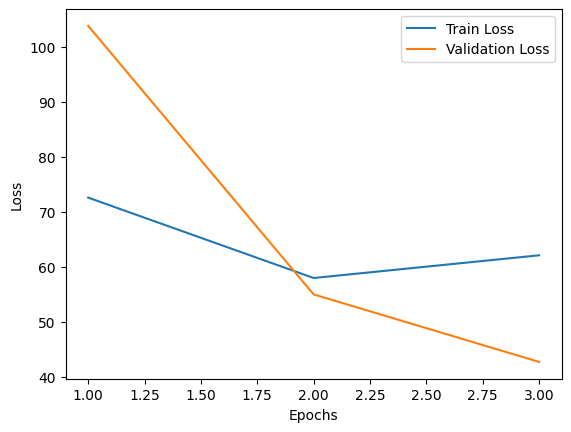

In [16]:
# Affichage des courbes de perte
epochs = range(1, 4)
plt.plot(epochs,train_losses, label='Train Loss')
plt.plot(epochs,val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
# model
weight_folder = 'weight'
model_path = os.path.join(weight_folder, 'best_model.pth')
checkpoint = torch.load(model_path)
model = RIDNet(in_channels=3, num_features=128)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# criterion = checkpoint['loss']

model

RIDNet(
  (head): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (eam1): EAM(
    (r1): Merge_And_Run_Dual(
      (part1): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
        (3): ReLU(inplace=True)
      )
      (part2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
        (3): ReLU(inplace=True)
      )
      (part3): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (r2): ResidualBlock(
      (body): Sequential(
        (0): Conv2d(128, 128, kernel_siz

<h4 style="background-color:#A8F4FF;font-family:Serif;font-size:200%;color: #000;text-align:center;border-radius: 50px 50px;"> Continuous training</h4>

In [11]:
train_losses = []
val_losses = []
psnr_metrics = []

def train_continuous(epochs, batch_size):


    EPOCHS = epochs
    BATCH_SIZE = batch_size

   
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        print(device)
        
    else:
        device = torch.device('cpu')
        print("CUDA n'est pas disponible, utilisation de CPU.")
    
    train_loader = get_train_loader(dataset_path="./data", batch_size=BATCH_SIZE)

    val_loader = get_val_loader(dataset_path="./val_data", batch_size=BATCH_SIZE)

    
    weight_folder = 'weight'
    model_path = os.path.join(weight_folder, 'best_model.pth')

    checkpoint = torch.load(model_path)
    model = RIDNet(in_channels=3, num_features=128)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    ratio = 0.35  
    criterion = L1_L2_Loss(ratio).to(device)
   
  

    best_val_loss = inf
    
    for epoch in range(1, EPOCHS+1):
        train_loss = 0.
        val_loss = 0.
        psnr = 0.

        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

        model.train()
        for i, data in loop:
            noisy = data['noisy'].to(device)
            clean = data['clean'].to(device)

            optimizer.zero_grad()
            pred = model(noisy)
            loss = criterion(pred, clean) # pred, gt
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_description(f'Epoch [{epoch}/{EPOCHS}')
        
        
        model.eval()
        with torch.no_grad():
            loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)

            for j, data in loop:
                noisy = data['noisy'].to(device)
                clean = data['clean'].to(device)

                pred = model(noisy)
                
                loss = criterion(pred, clean)
                val_loss += loss.item()
                loop.set_description(f'valid')

                psnr += PSNR(noisy, clean)

        
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        psnr = psnr / len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        psnr_metrics.append(psnr)

        print(f'Epoch: {epoch}\t train_loss: {train_loss}\t val_loss: {val_loss}')

        if best_val_loss > val_loss:
            # print('=' * 100)
            print('=' * 100)
            print(f'val_loss is improved from {best_val_loss:.8f} to {val_loss:.8f}\t saved current weight')
            print('=' * 100)
            best_val_loss = val_loss

            # torch.save
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': criterion},
                        'weight/best_model_continuous.pth')

 

In [12]:
if __name__ == '__main__':
    seed_everything(42)
    train_continuous(5,4)

CUDA n'est pas disponible, utilisation de CPU.


Epoch: 1	 train_loss: 0.1580846428871155	 val_loss: 0.24640540778636932
val_loss is improved from inf to 0.24640541	 saved current weight


Epoch: 2	 train_loss: 0.21540969759225845	 val_loss: 0.2573908716440201


Epoch: 3	 train_loss: 0.2940495252609253	 val_loss: 0.2232808917760849
val_loss is improved from 0.24640541 to 0.22328089	 saved current weight


Epoch: 4	 train_loss: 0.18041467666625977	 val_loss: 0.14217069745063782
val_loss is improved from 0.22328089 to 0.14217070	 saved current weight


Epoch: 5	 train_loss: 0.13651404082775115	 val_loss: 0.17111725360155106


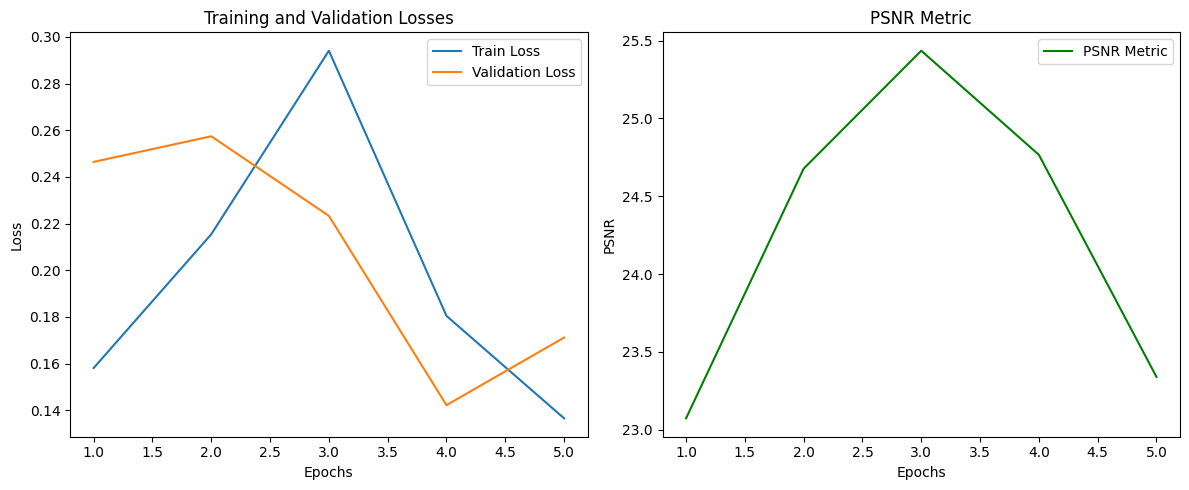

In [16]:
epochs = range(1, 6)

# Plot des courbes de perte
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # Sous-graphique pour les courbes de perte
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()

# Plot de la métrique PSNR
plt.subplot(1, 2, 2)  # Sous-graphique pour la métrique PSNR
plt.plot(epochs, psnr_metrics, label='PSNR Metric', color='green')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.title('PSNR Metric')
plt.legend()

plt.tight_layout()
plt.show()
